# Module 2 Task 2: Exploratory Data Analysis - Box Builder Dataset

This notebook contains the exploratory data analysis of the `sampled_box_builder_df.csv` dataset, where each row represents an (order, product) pair with an outcome variable indicating whether the product was purchased or not.


## 1. Initial Setup and Configuration

In [2]:
# Required imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import boto3
from dotenv import load_dotenv
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

load_dotenv()
AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")

## 2. Data Loading

In [10]:
S3_PATH = "s3://zrive-ds-data/groceries/box_builder_dataset/feature_frame.csv"
LOCAL_DATA_PATH = 'box_builder_data/'
LOCAL_FILE_PATH = LOCAL_DATA_PATH + 'feature_frame.csv'

def download_box_builder_data():
    """Download box builder dataset from S3 if not exists locally."""
    os.makedirs(LOCAL_DATA_PATH, exist_ok=True)
    
    if os.path.exists(LOCAL_FILE_PATH):
        print(f"File already exists at {LOCAL_FILE_PATH}")
        return
    
    try:
        s3 = boto3.client('s3',
                         aws_access_key_id=AWS_ACCESS_KEY_ID,
                         aws_secret_access_key=AWS_SECRET_ACCESS_KEY)
        
        bucket_name = 'zrive-ds-data'
        key = 'groceries/box_builder_dataset/feature_frame.csv'
        
        print(f"Downloading from {S3_PATH}")
        s3.download_file(bucket_name, key, LOCAL_FILE_PATH)
        print(f"File downloaded successfully to {LOCAL_FILE_PATH}")
        
    except Exception as e:
        print(f"Error downloading file: {e}")

# Download data if needed
download_box_builder_data()

# Load the dataset
box_builder_df = pd.read_csv(LOCAL_FILE_PATH)
print(f"Dataset shape: {box_builder_df.shape}")


File downloaded successfully to box_builder_data/feature_frame.csv
Dataset shape: (2880549, 27)


## 3. First Look at the Data

In [13]:
box_builder_df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [15]:
box_builder_df.columns

Index(['variant_id', 'product_type', 'order_id', 'user_id', 'created_at',
       'order_date', 'user_order_seq', 'outcome', 'ordered_before',
       'abandoned_before', 'active_snoozed', 'set_as_regular',
       'normalised_price', 'discount_pct', 'vendor', 'global_popularity',
       'count_adults', 'count_children', 'count_babies', 'count_pets',
       'people_ex_baby', 'days_since_purchase_variant_id',
       'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
       'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
       'std_days_to_buy_product_type'],
      dtype='object')

## 4. Data Quality Checks

### 4.1. Basic Data Validation


In [16]:
# Check for duplicates
duplicate_count = box_builder_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# Check missing values
missing_values = box_builder_df.isnull().sum()
missing_percentage = (missing_values / len(box_builder_df)) * 100

print("\nMissing values analysis:")
for col, count in missing_values[missing_values > 0].items():
    print(f"{col}: {count} ({missing_percentage[col]:.2f}%)")

Number of duplicate rows: 0

Missing values analysis:


### 4.2. Data Types and Consistency

In [17]:
# Check data types
print("Data types:")
print(box_builder_df.dtypes)

Data types:
variant_id                            int64
product_type                         object
order_id                              int64
user_id                               int64
created_at                           object
order_date                           object
user_order_seq                        int64
outcome                             float64
ordered_before                      float64
abandoned_before                    float64
active_snoozed                      float64
set_as_regular                      float64
normalised_price                    float64
discount_pct                        float64
vendor                               object
global_popularity                   float64
count_adults                        float64
count_children                      float64
count_babies                        float64
count_pets                          float64
people_ex_baby                      float64
days_since_purchase_variant_id      float64
avg_days_to_buy_vari

In [18]:
# Check for any infinite values
inf_check = box_builder_df.replace([np.inf, -np.inf], np.nan).isnull().sum() - missing_values
print("\nInfinite values check:")
for col, count in inf_check[inf_check > 0].items():
    print(f"{col}: {count} infinite values")


Infinite values check:


## 5. Descriptive Statistics

### 5.1. Numerical Features Overview

In [24]:
numerical_cols = box_builder_df.select_dtypes(include=[np.number]).columns
print(numerical_cols)
box_builder_df[numerical_cols].describe()

Index(['variant_id', 'order_id', 'user_id', 'user_order_seq', 'outcome',
       'ordered_before', 'abandoned_before', 'active_snoozed',
       'set_as_regular', 'normalised_price', 'discount_pct',
       'global_popularity', 'count_adults', 'count_children', 'count_babies',
       'count_pets', 'people_ex_baby', 'days_since_purchase_variant_id',
       'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
       'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
       'std_days_to_buy_product_type'],
      dtype='object')


,variant_id,order_id,user_id,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
count,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06,...,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06,2.880549e+06
mean,3.401250e+13,2.978388e+12,3.750025e+12,3.289342e+00,1.153669e-02,2.113868e-02,6.092589e-04,2.290188e-03,3.629864e-03,1.272808e-01,...,5.492182e-02,3.538562e-03,5.134091e-02,2.072549e+00,3.312961e+01,3.523734e+01,2.645304e+01,3.143513e+01,3.088810e+01,2.594969e+01
std,2.786246e+11,2.446292e+11,1.775710e+11,2.140176e+00,1.067876e-01,1.438466e-01,2.467565e-02,4.780109e-02,6.013891e-02,1.268378e-01,...,3.276586e-01,5.938048e-02,3.013646e-01,3.943659e-01,3.707162e+00,1.057766e+01,7.168323e+00,1.227511e+01,4.330262e+00,3.278860e+00
min,3.361529e+13,2.807986e+12,3.046041e+12,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.599349e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.414214e+00,0.000000e+00,7.000000e+00,2.828427e+00
25%,3.380354e+13,2.875152e+12,3.745901e+12,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.394416e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,3.300000e+01,3.000000e+01,2.319372e+01,3.000000e+01,2.800000e+01,2.427618e+01
50%,3.397325e+13,2.902856e+12,3.812775e+12,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.105178e-02,...,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,3.300000e+01,3.400000e+01,2.769305e+01,3.000000e+01,3.100000e+01,2.608188e+01
75%,3.428495e+13,2.922034e+12,3.874925e+12,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.352670e-01,...,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,3.300000e+01,4.000000e+01,3.059484e+01,3.000000e+01,3.400000e+01,2.796118e+01
max,3.454300e+13,3.643302e+12,5.029635e+12,2.100000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,3.000000e+00,1.000000e+00,6.000000e+00,5.000000e+00,1.480000e+02,8.400000e+01,5.868986e+01,1.480000e+02,3.950000e+01,3.564191e+01


### 5.2. Categorical Features Overview

In [21]:
categorical_cols = box_builder_df.select_dtypes(include=['object', 'category']).columns
print(f"Categorical columns: {categorical_cols.tolist()}")

for col in categorical_cols[:5]: 
    print(f"\n{col} value counts:")
    print(box_builder_df[col].value_counts())

Categorical columns: ['product_type', 'created_at', 'order_date', 'vendor']

product_type value counts:
product_type
tinspackagedfoods         226474
condimentsdressings       129749
ricepastapulses           128098
haircare                  114978
cookingingredientsoils    110686
                           ...  
babyfood12months            6797
householdsundries           6735
petcare                     4075
feedingweaning              2790
premixedcocktails           2620
Name: count, Length: 62, dtype: int64

created_at value counts:
created_at
2021-03-03 14:42:05    976
2021-03-03 11:36:16    976
2021-03-02 22:36:33    976
2021-03-02 23:56:57    976
2021-03-03 00:33:51    976
                      ... 
2020-10-06 10:50:23    614
2020-10-06 08:57:59    611
2020-10-05 20:08:53    608
2020-10-05 17:59:51    608
2020-10-05 16:46:19    608
Name: count, Length: 3446, dtype: int64

order_date value counts:
order_date
2021-02-17 00:00:00    68446
2021-02-25 00:00:00    60488
2021-03-01 00

## 6. Target Variable Analysis

Target variable (outcome) distribution:
outcome
0.0    2847317
1.0      33232
Name: count, dtype: int64

Target variable proportion:
outcome
0.0    0.988463
1.0    0.011537
Name: proportion, dtype: float64


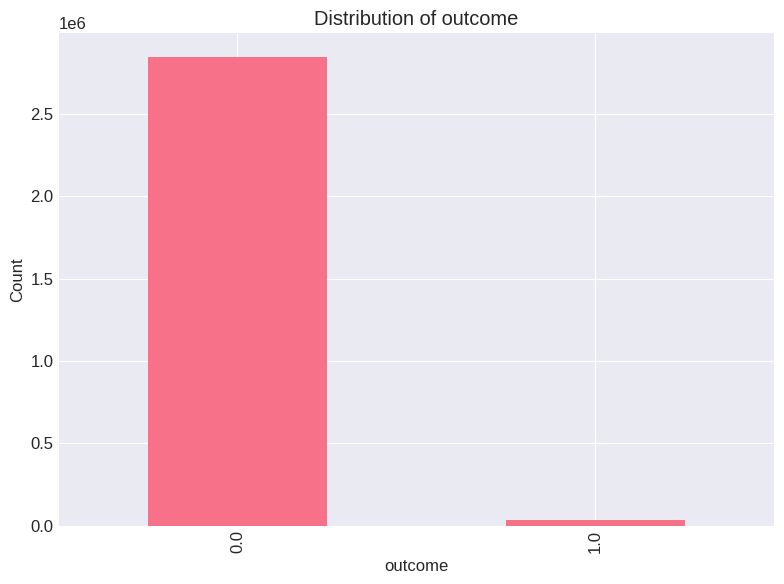

In [ ]:
# Assuming 'outcome' is our target variable
target_column = 'outcome'

if target_column in box_builder_df.columns:
    print(f"Target variable ({target_column}) distribution:")
    print(box_builder_df[target_column].value_counts())
    print(f"\nTarget variable proportion:")
    print(box_builder_df[target_column].value_counts(normalize=True))
    
    # Visualize target distribution
    plt.figure(figsize=(8, 6))
    box_builder_df[target_column].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {target_column}')
    plt.xlabel(target_column)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

## 7. Univariate Analysis

### 7.1. Numerical Feature Distributions

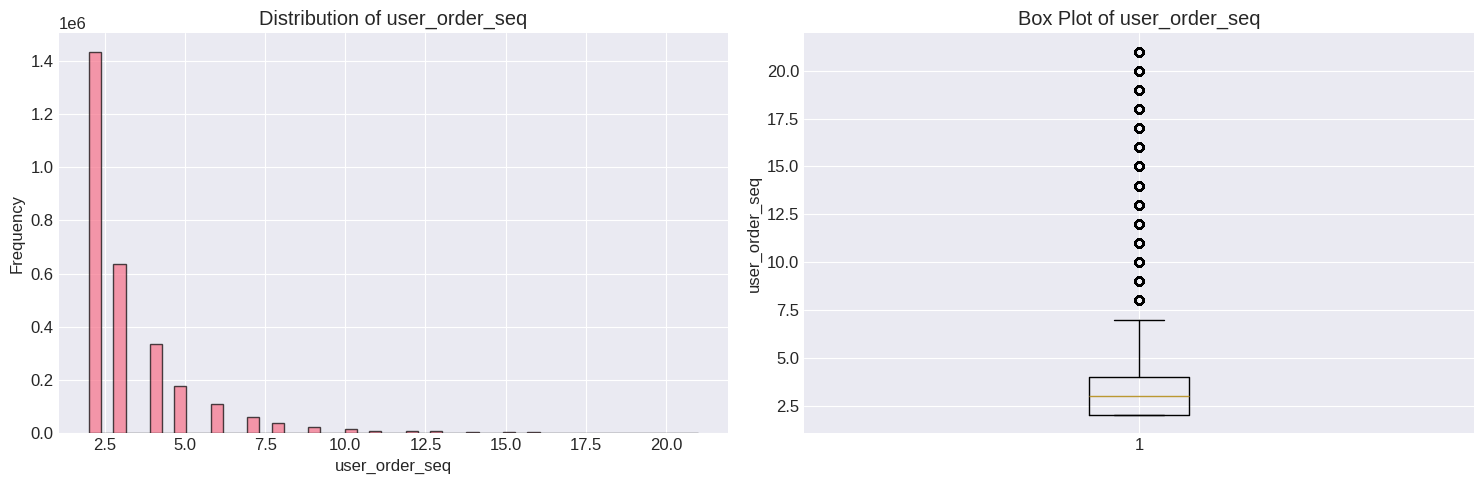

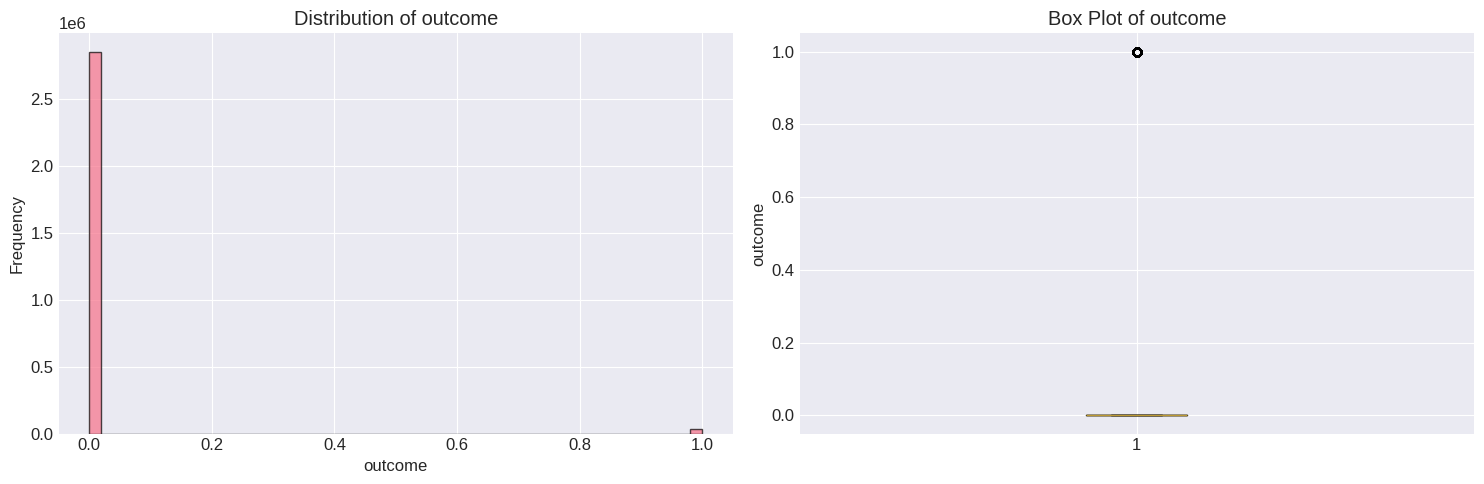

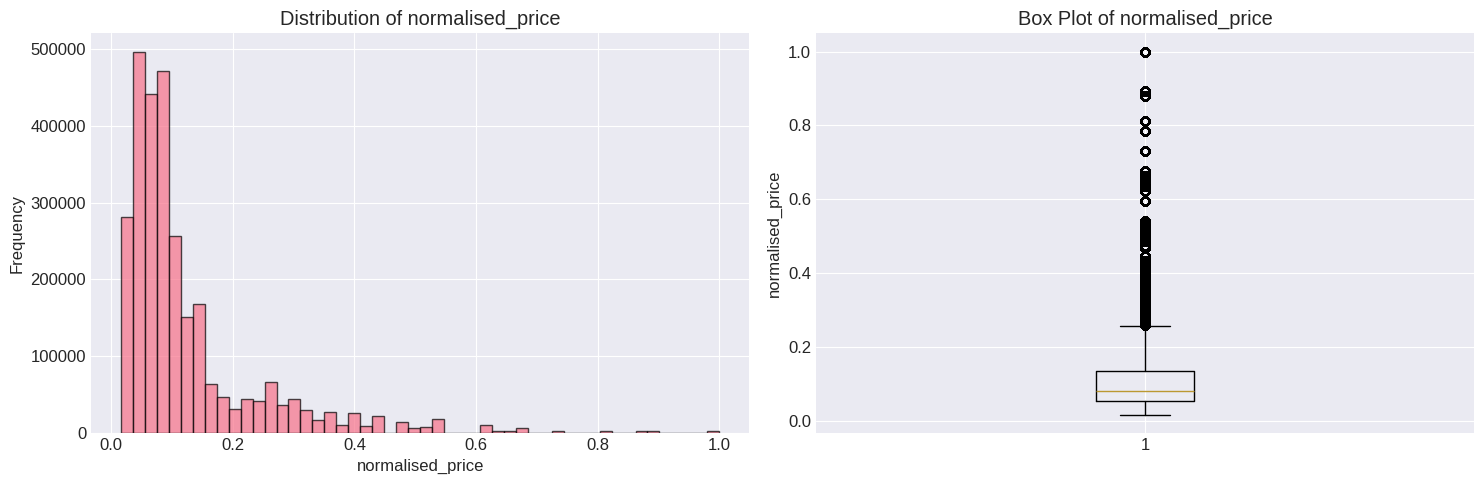

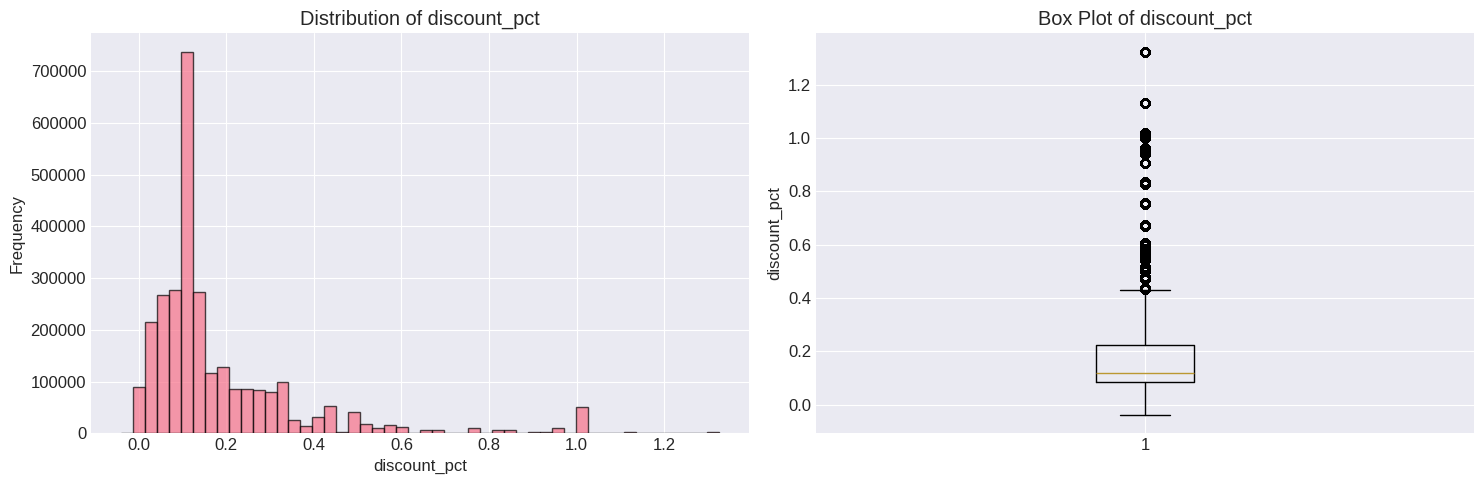

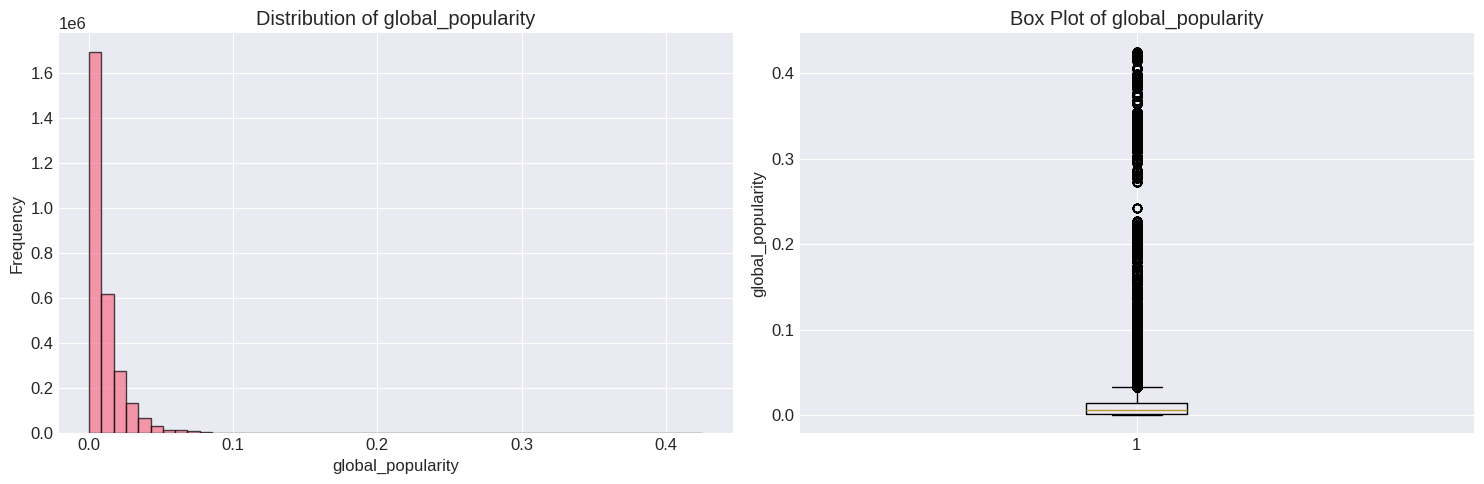

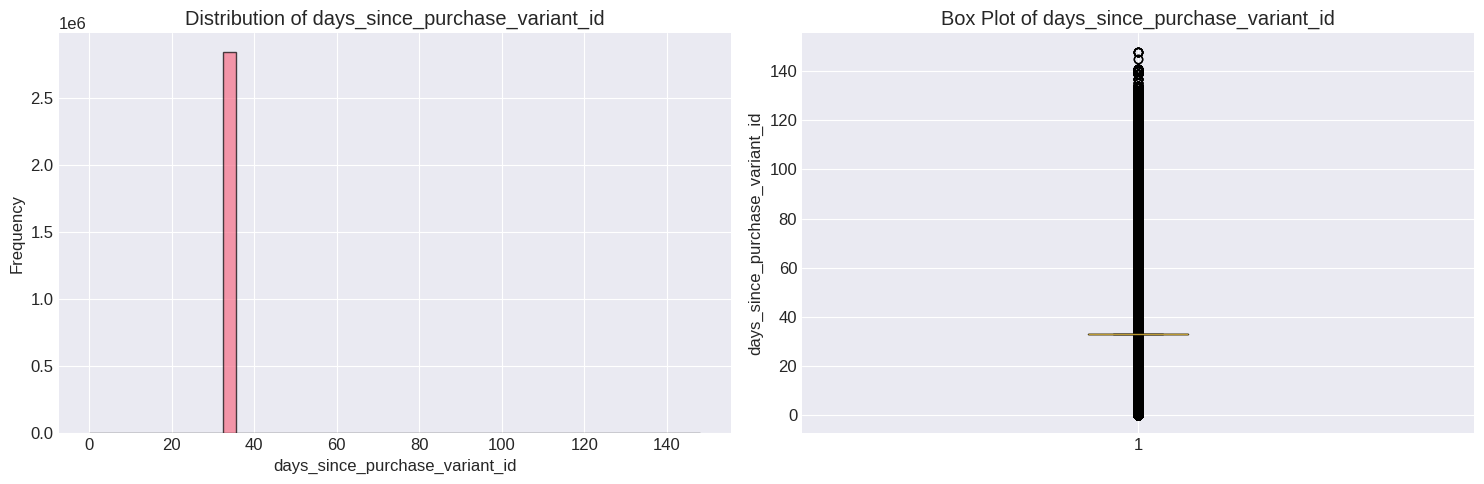

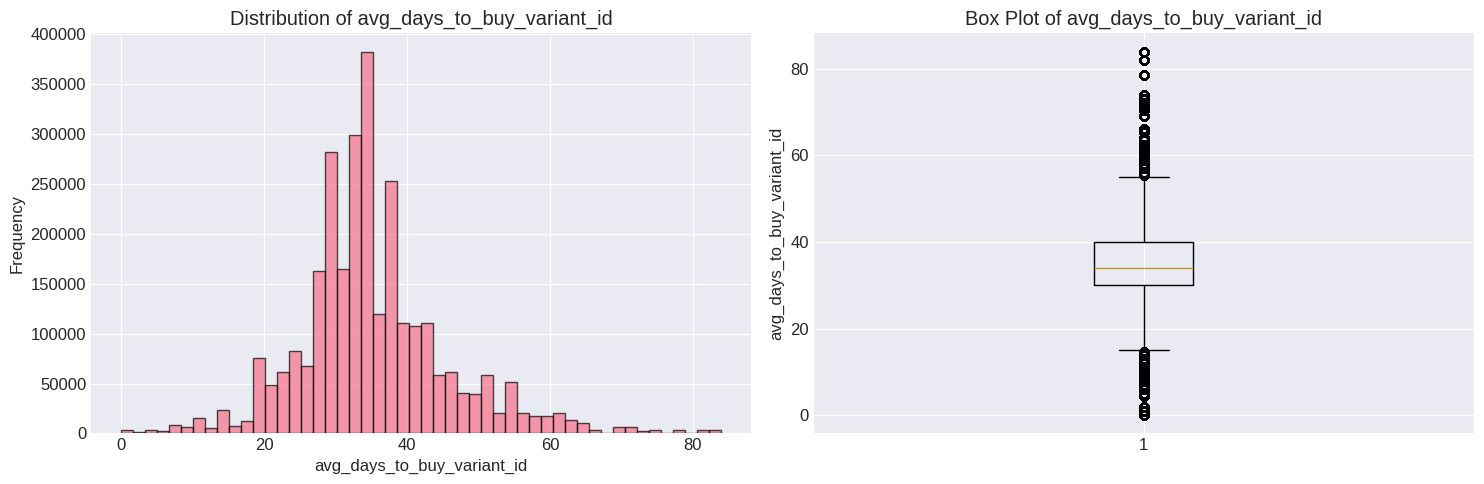

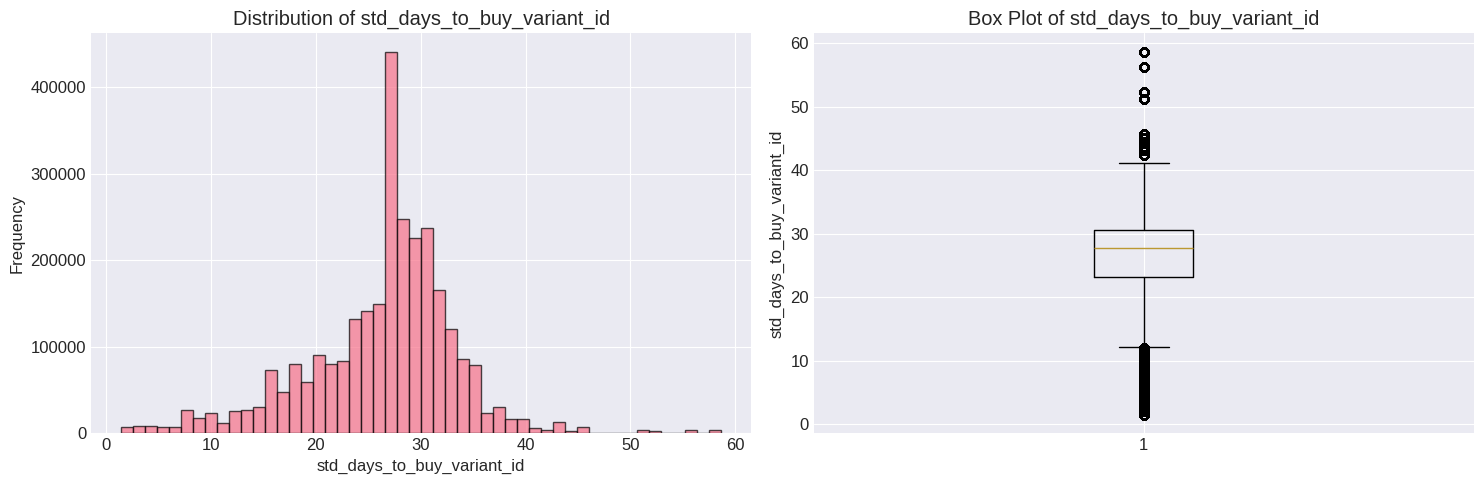

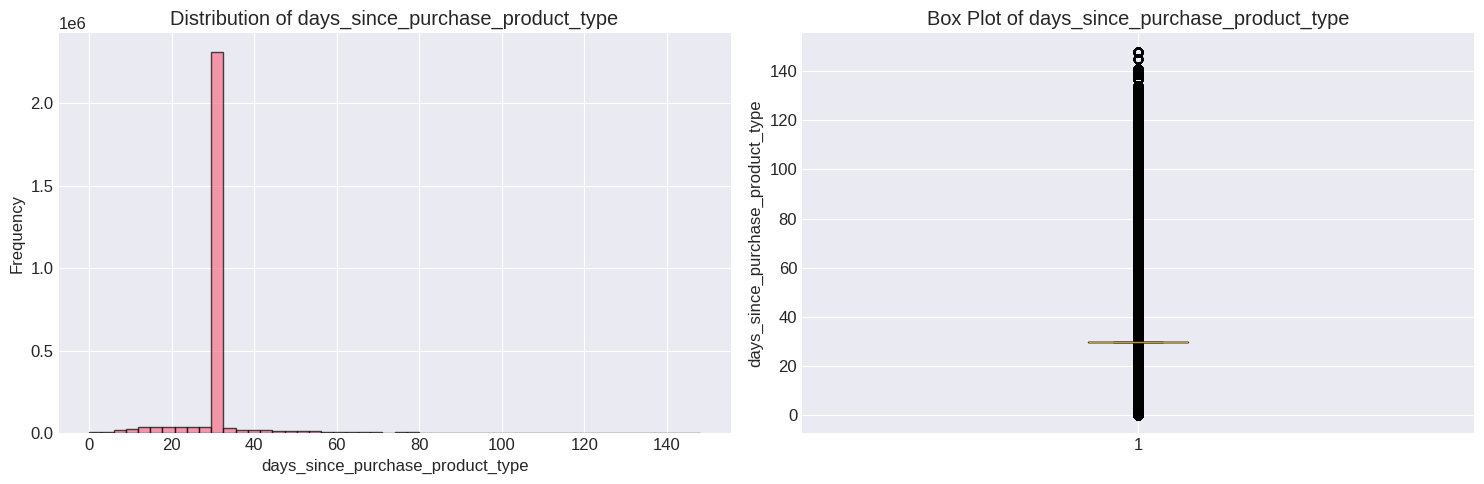

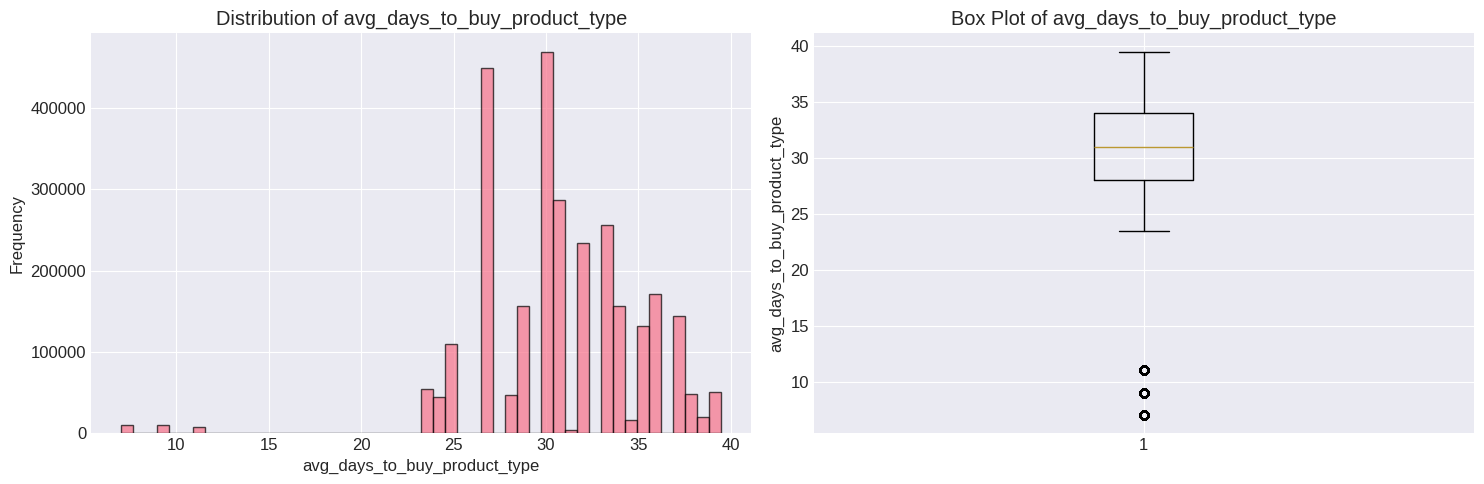

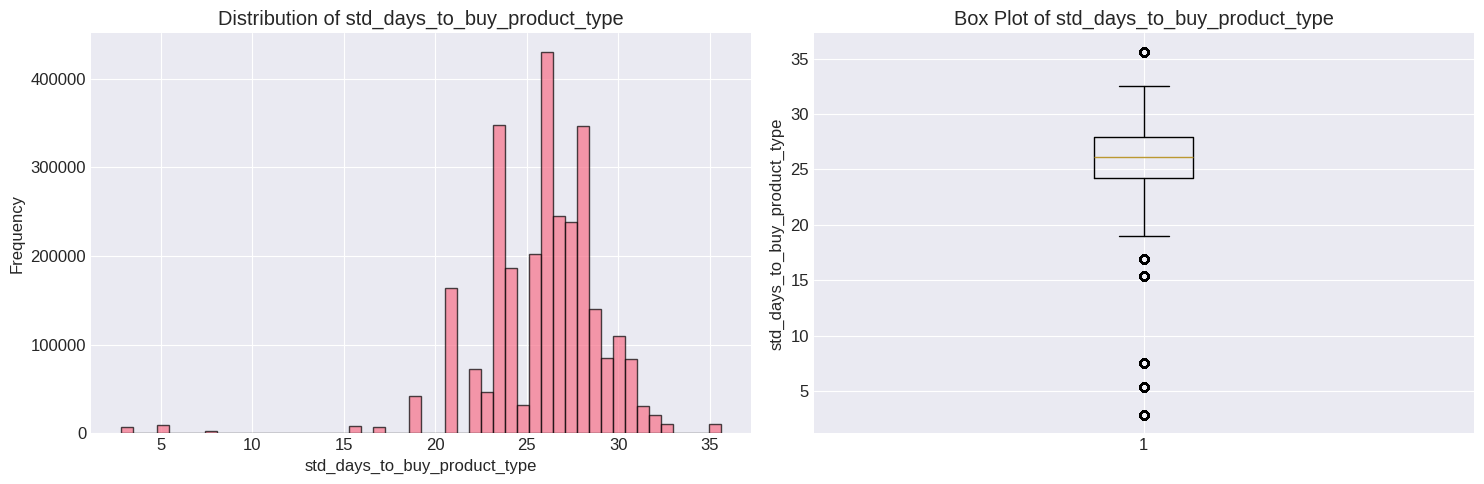

In [37]:
# Select interesting numerical columns 
cols = ['user_order_seq', 'outcome', 'normalised_price', 'discount_pct',
       'global_popularity','days_since_purchase_variant_id',
       'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
       'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
       'std_days_to_buy_product_type']
for col in cols:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Histogram
    ax1.hist(box_builder_df[col].dropna(), bins=50, alpha=0.7, edgecolor='black')
    ax1.set_title(f'Distribution of {col}')
    ax1.set_xlabel(col)
    ax1.set_ylabel('Frequency')
    
    # Box plot
    ax2.boxplot(box_builder_df[col].dropna())
    ax2.set_title(f'Box Plot of {col}')
    ax2.set_ylabel(col)
    
    plt.tight_layout()
    plt.show()

### 7.2. Categorical Feature Distributions

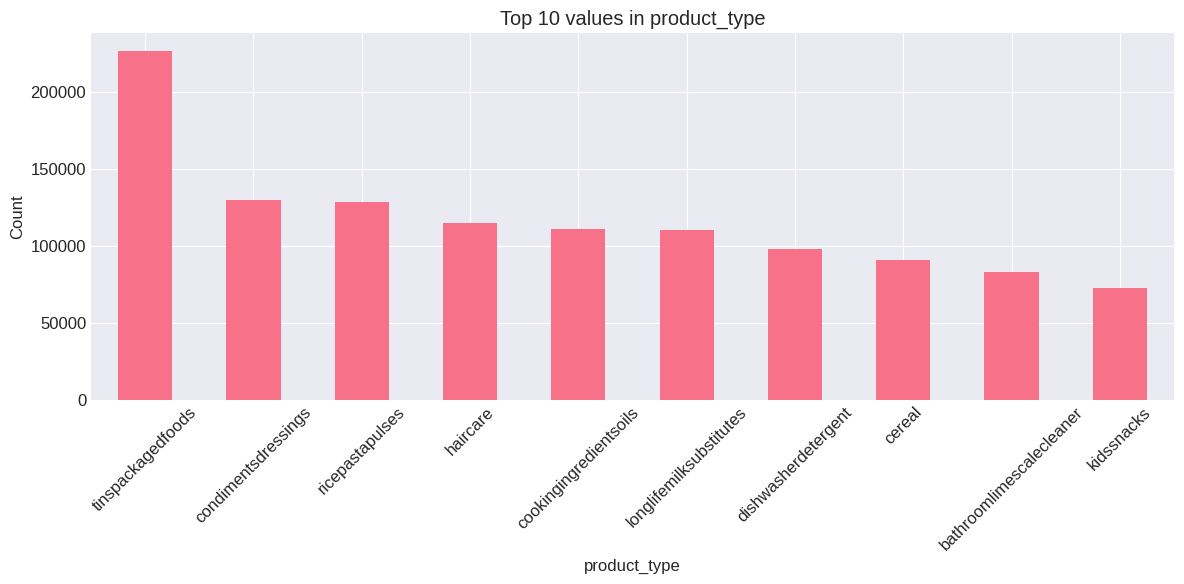

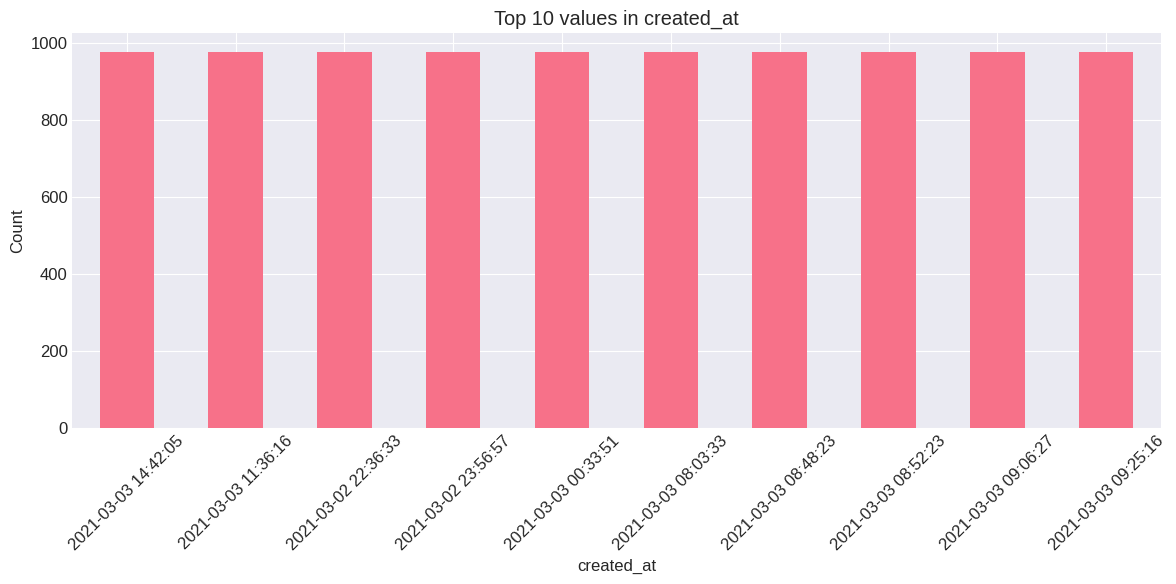

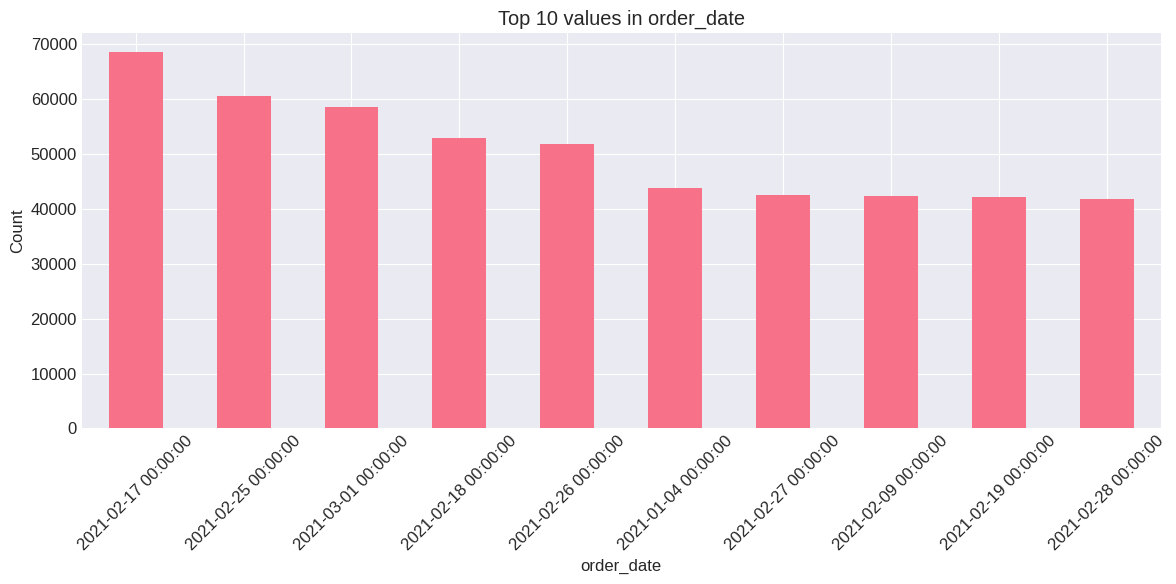

In [32]:
# Plot distribution of categorical features
for col in categorical_cols[:3]:  # Limit to first 3
    plt.figure(figsize=(12, 6))
    value_counts = box_builder_df[col].value_counts()
    
    if len(value_counts) > 10:
        value_counts = value_counts.head(10)
        title = f'Top 10 values in {col}'
    else:
        title = f'Distribution of {col}'
    
    value_counts.plot(kind='bar')
    plt.title(title)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## 8. Correlation Analysis

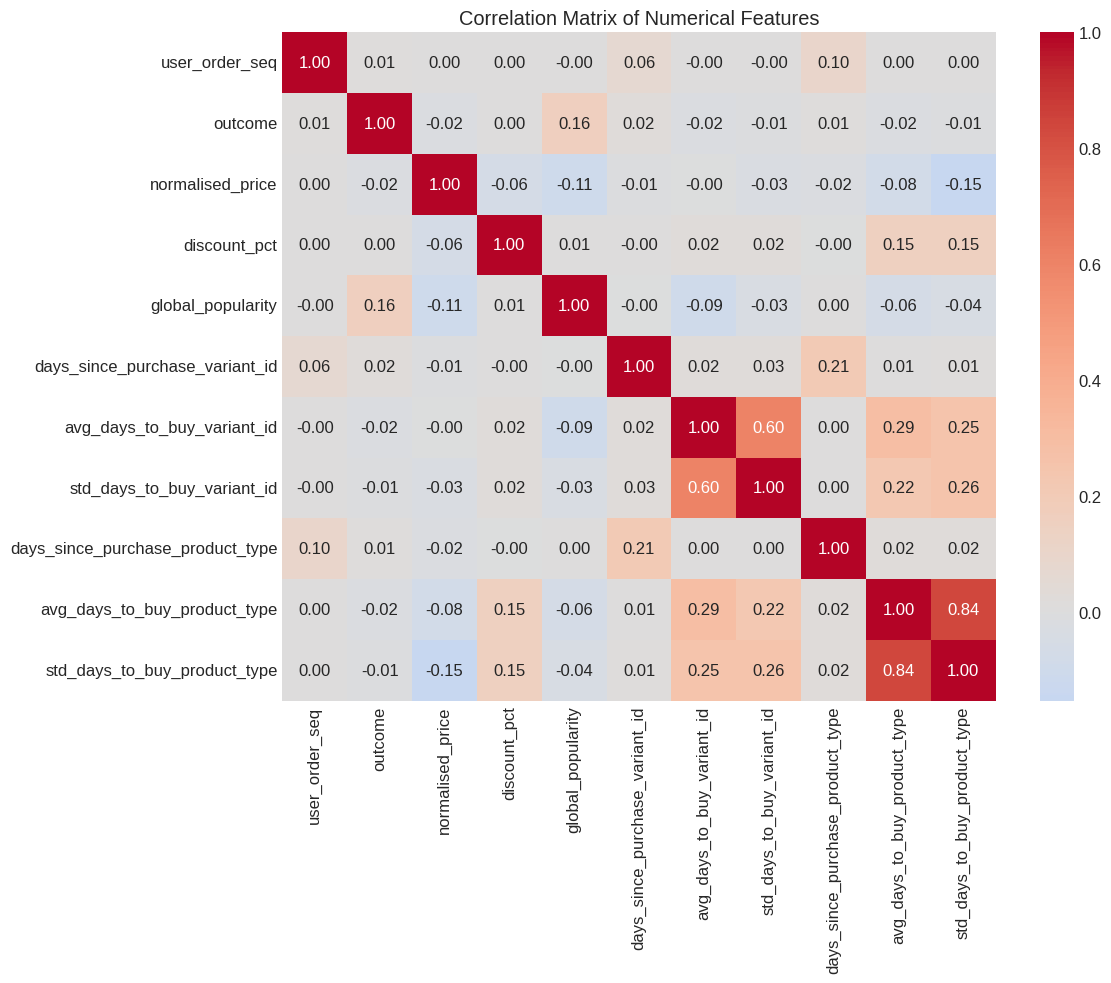

In [35]:
# Correlation matrix for numerical features
correlation_matrix = box_builder_df[cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()